# Mask R-CNN Instance Segmentation

In the previous notebooks, we performed object detection, where bounding boxes were used to indicate the objects contained in an image.  In this notebook, we will introduce [Mask R-CNN](https://arxiv.org/abs/1703.06870) for instance segmentation.  In other words, we will get the contours or masks of objects in an image besides bounding boxes.

## Image Segmentation

Image segmentation categorises pixels in an image into different groups in terms of some criteria, such as semantic segmentation and instance segmentation.  In this notebook, we are interested in instance segmentation which will not only detect the known objects in an image with bounding boxes, but also find which pixels belong to the objects using masks.

![Segmentation Comparison](media/segmentaion_comparison.png)

## Mask R-CNN

[Mask R-CNN](https://arxiv.org/abs/1703.06870) is an instance segmentation alrogithm based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497) and adds an extra branch for predicting segmentation masks for objects (instances).  That is, the same feature map for training the RPN (Region Proposal Network) and classifier in Faster R-CNN is also used in Mask R-CNN by a FCN (Fully Convolutional Network) to predict a binary mask for the object inside a bounding box.

![Mask R-CNN Framework](media/mask-r-cnn-framework.png)

## Initialization

In [1]:
# ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# imports
import numpy as np
import scrapbook as sb

from pathlib import Path
from PIL import Image

# torch
import torch

# utility
import sys
sys.path.append("../../")

from utils_cv.common.data import data_path, unzip_url, get_files_in_directory
from utils_cv.common.gpu import which_processor
from utils_cv.common.plot import show_ims
from utils_cv.detection.data import Urls, coco_labels
from utils_cv.detection.dataset import DetectionDataset, parse_pascal_voc_anno
from utils_cv.detection.mask import merge_binary_masks
from utils_cv.detection.model import DetectionLearner, get_pretrained_maskrcnn
from utils_cv.detection.plot import display_bboxes_mask, plot_pr_curves

which_processor()

Torch is using GPU: Quadro P400


In [3]:
# variables
DEVICE = "cuda"
DATA_PATH = unzip_url(Urls.fridge_objects_mask_path, exist_ok=True)
EPOCHS = 10
THRESHOLD = 0.5

## Browse the Dataset

We are going to use the [odFridgeObjects-mask datasets](https://cvbp.blob.core.windows.net/public/datasets/object_detection/odFridgeObjectsMask.zip) for illustration.  The dataset has already downloaded and unzipped into `DATA_PATH`.  This dataset includes 31 images of 4 class labels: `can`, `carton`, `milk_bottle` and `water_bottle`.

```
odFridgeObjects-mask/
├── annotations
│   ├── 1.xml
│   ├── 2.xml
│   ├── ...
│   ├── 30.xml
│   └── 31.xml
├── images
│   ├── 1.jpg
│   ├── 2.jpg
│   ├── ...
│   ├── 30.jpg
│   └── 31.jpg
└── segmentation-masks
    ├── 1.png
    ├── 2.png
    ├── ...
    ├── 30.png
    └── 31.png
```

The `images` and `segmentation-masks` directory contain original images and their corresponding masks.  The annotations in the `annotations` directory are of format [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) shown as in [01_training_introduction notebook](01_training_introduction.ipynb).

In [4]:
# list of the paths of images, masks and annotations,
# sorting them to ensure that they are aligned
subdirs = ['images', 'segmentation-masks', 'annotations']
subdir_paths = [Path(DATA_PATH) / s for s in subdirs]
im_list, mask_list, annotation_list = (
    get_files_in_directory(p) for p in subdir_paths
)

# the 18th image, mask and annotation
im_path, mask_path, annotation_path = map(
    lambda x: x[18], 
    (im_list, mask_list, annotation_list)
)

Masks are grayscale images where the value of pixels belong to a specific object are the object id indexed from 1.

**NOTE**: When preparing the dataset, we must make sure the order of objects in the mask image be the same as in the annotation file.  In other words, for the following image, the value of `water_bottle`'s pixels must be 1 and that of `milk_bottle` must be 2.

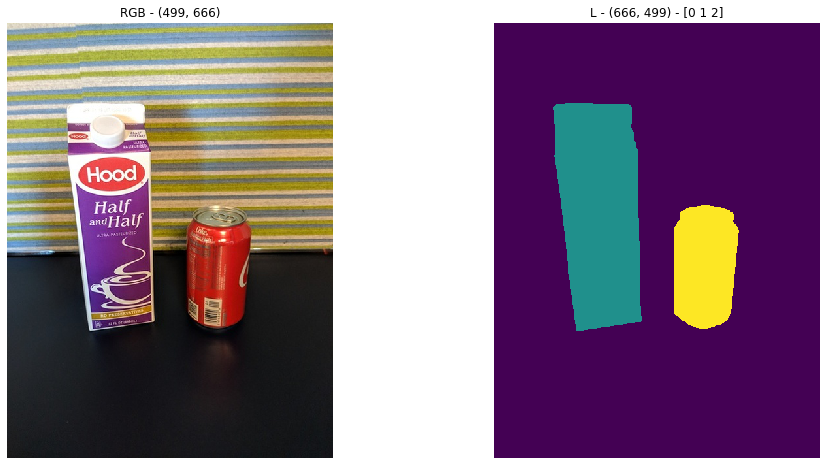

In [5]:
# view the 18th image and its mask
im = Image.open(im_path)
mask = Image.open(mask_path)
mask_np = np.array(mask)
im_label = f'{im.mode} - {im.size}'
mask_label = f'{mask.mode} - {mask_np.shape} - {np.unique(mask_np)}'

show_ims([im_path, mask_path], [im_label, mask_label], size=8)

`parse_pascal_voc_anno()` can be used to get `AnnotationBbox` bounding boxes from the annotation file.  Putting together the mask and the bounding boxes, we get:

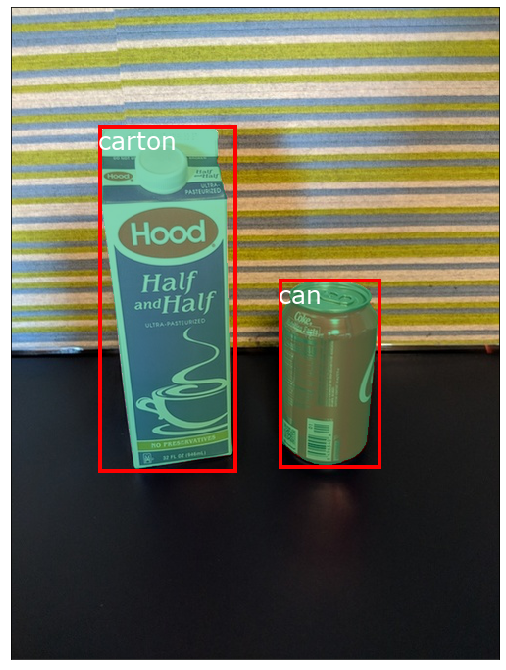

In [6]:
# plot bounding boxes and masks
bboxes, _ = parse_pascal_voc_anno(annotation_path)
display_bboxes_mask(bboxes, im_path, mask_path)

## Instance Segmentation with Pretrained Mask R-CNN Model

We will use the pretrained [Mask R-CNN ResNet-50 FPN](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn) in PyTorch for instance segmentation.  As described on [this torchvision page](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn), the model is pretrained on [COCO train2017](http://images.cocodataset.org/zips/train2017.zip) (18GB).  It expects a list of images as `List[Tensor[C, H, W]]` in the range of `0-1` and returns the predictions as `List[Dict[Tensor]]`.  The fields of the `Dict` include `scores`, `labels`, `boxes` and `masks`, each of which is of the same length as the input image list.  The `labels` belong to the 91 categories in the [COCO datasets](http://cocodataset.org/).

Similar to [01_training_introduction notebook](01_training_introduction.ipynb), we can use `get_pretrained_maskrcnn()` to get the pretrained Mask R-CNN model to create a `DetectionLearner`.

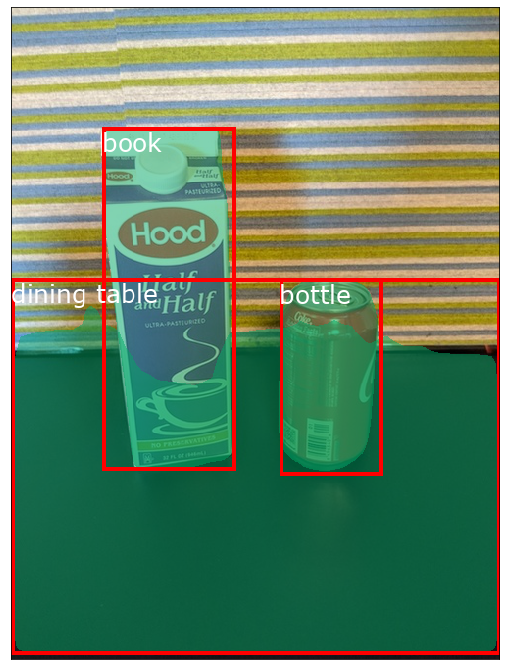

In [7]:
# get pretrained model
detector = DetectionLearner(
    model=get_pretrained_maskrcnn(), 
    device=torch.device(DEVICE),
    labels=coco_labels()[1:],
)
# predict
pred = detector.predict(im_path, threshold=THRESHOLD)
# plot
display_bboxes_mask(pred["det_bboxes"], im_path, pred["masks"])

The model detected the unexpeced "dining table" and mistaken the "carton" as a "book".  That is because the [COCO](http://cocodataset.org/) has a class called "dining table" and does not include the class "carton".

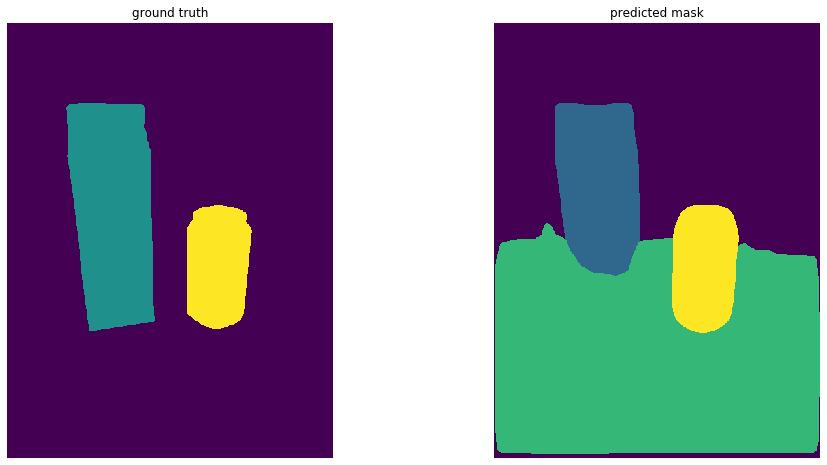

In [8]:
# compare ground truth and predicted mask
pred_mask_path = str(data_path() / "pred_mask.png")
Image.fromarray(merge_binary_masks(pred["masks"])).save(pred_mask_path)
show_ims(
    [mask_path, pred_mask_path],
    ['ground truth', 'predicted mask'],
    size=8
)

## Finetuning Mask R-CNN model

Since there are no "carton", "milk bottle" and "water bottle" in the labels of COCO datasets, we need to fine-tune the pre-trained Mask R-CNN model for odFridgeObjects-mask with the 4 labels and get rid of the other unexpected categories, such as "dining table".  Following the practice in our [01_training_introduction notebook](01_training_introduction.ipynb), we need to prepare the `DetectionDataset` to be used by the `DetectionLearner` with a customized Mask R-CNN model.  To prepare a custom dataset, there should be a separate directory containing the masks demontrated in the above.

### Prepare Dataset and Load Images

To load the data, we need to create a Dataset object class that Torchvision knows how to use.  To make it more convinient, we've created a DetectionDataset class that knows how to extract annotation information from the Pascal VOC format and meet the requirements of the Torchvision dataset object class.  There is an additional parameter `mask_dir` for specifying the mask directory.

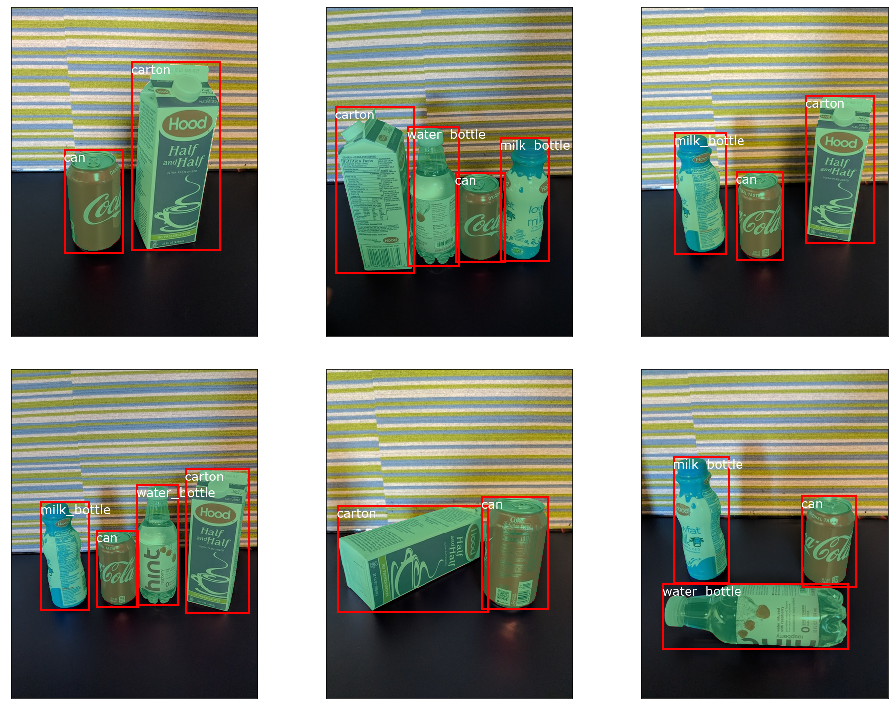

In [9]:
mask_data = DetectionDataset(root=DATA_PATH, mask_dir='segmentation-masks')
mask_data.show_ims(rows=2, seed=168)

### Re-train

We provide the `get_pretrained_maskrcnn()` function to facilitate the customization of Mask R-CNN model with a ResNet-50-FPN backbone.

In [10]:
# train
detector = DetectionLearner(
    dataset=mask_data,
    model=get_pretrained_maskrcnn(len(mask_data.labels)+1),
    device=torch.device(DEVICE))
detector.fit(epochs=EPOCHS, lr=0.005, print_freq=30)

Epoch: [0]  [ 0/18]  eta: 0:04:13  lr: 0.000299  loss: 4.3164 (4.3164)  loss_classifier: 2.1161 (2.1161)  loss_box_reg: 0.1256 (0.1256)  loss_mask: 2.0664 (2.0664)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 14.0716  data: 0.6639  max mem: 0
Epoch: [0]  [17/18]  eta: 0:00:13  lr: 0.005000  loss: 1.3410 (1.8406)  loss_classifier: 0.3658 (0.7039)  loss_box_reg: 0.2130 (0.2115)  loss_mask: 0.4959 (0.9048)  loss_objectness: 0.0034 (0.0086)  loss_rpn_box_reg: 0.0108 (0.0118)  time: 13.0664  data: 0.0413  max mem: 0
Epoch: [0] Total time: 0:03:55 (13.0714 s / it)
creating index...
index created!
Test:  [ 0/18]  eta: 0:05:14  model_time: 12.6555 (12.6555)  evaluator_time: 0.1734 (0.1734)  time: 17.4476  data: 1.1027  max mem: 0
Test:  [17/18]  eta: 0:00:11  model_time: 11.7528 (11.4838)  evaluator_time: 0.1439 (0.1483)  time: 11.8974  data: 0.0651  max mem: 0
Test: Total time: 0:03:34 (11.9244 s / it)
Averaged stats: model_time: 11.7528 (11.4838)  evaluator_tim

Epoch: [3]  [ 0/18]  eta: 0:04:53  lr: 0.005000  loss: 0.3938 (0.3938)  loss_classifier: 0.1759 (0.1759)  loss_box_reg: 0.1188 (0.1188)  loss_mask: 0.0895 (0.0895)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0095 (0.0095)  time: 16.3021  data: 1.8307  max mem: 0
Epoch: [3]  [17/18]  eta: 0:00:13  lr: 0.005000  loss: 0.3456 (0.3361)  loss_classifier: 0.1568 (0.1581)  loss_box_reg: 0.0815 (0.0832)  loss_mask: 0.0820 (0.0856)  loss_objectness: 0.0005 (0.0010)  loss_rpn_box_reg: 0.0076 (0.0082)  time: 13.6548  data: 0.1043  max mem: 0
Epoch: [3] Total time: 0:04:06 (13.6866 s / it)
creating index...
index created!
Test:  [ 0/18]  eta: 0:03:25  model_time: 9.7760 (9.7760)  evaluator_time: 0.0355 (0.0355)  time: 11.4215  data: 1.6098  max mem: 0
Test:  [17/18]  eta: 0:00:09  model_time: 9.9396 (9.6650)  evaluator_time: 0.0334 (0.0334)  time: 9.7926  data: 0.0939  max mem: 0
Test: Total time: 0:02:56 (9.8250 s / it)
Averaged stats: model_time: 9.9396 (9.6650)  evaluator_time: 0.033

Epoch: [6]  [ 0/18]  eta: 0:04:52  lr: 0.005000  loss: 0.1719 (0.1719)  loss_classifier: 0.0684 (0.0684)  loss_box_reg: 0.0309 (0.0309)  loss_mask: 0.0675 (0.0675)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 16.2587  data: 2.0197  max mem: 0
Epoch: [6]  [17/18]  eta: 0:00:13  lr: 0.005000  loss: 0.1519 (0.1547)  loss_classifier: 0.0579 (0.0594)  loss_box_reg: 0.0223 (0.0254)  loss_mask: 0.0601 (0.0634)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0053 (0.0063)  time: 13.5875  data: 0.1156  max mem: 0
Epoch: [6] Total time: 0:04:05 (13.6247 s / it)
creating index...
index created!
Test:  [ 0/18]  eta: 0:03:22  model_time: 9.4847 (9.4847)  evaluator_time: 0.0204 (0.0204)  time: 11.2708  data: 1.7654  max mem: 0
Test:  [17/18]  eta: 0:00:09  model_time: 9.8796 (9.7186)  evaluator_time: 0.0301 (0.0460)  time: 9.8672  data: 0.1019  max mem: 0
Test: Total time: 0:02:58 (9.9023 s / it)
Averaged stats: model_time: 9.8796 (9.7186)  evaluator_time: 0.030

Epoch: [9]  [ 0/18]  eta: 0:05:40  lr: 0.000500  loss: 0.1584 (0.1584)  loss_classifier: 0.0523 (0.0523)  loss_box_reg: 0.0306 (0.0306)  loss_mask: 0.0675 (0.0675)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0080 (0.0080)  time: 18.9299  data: 2.0633  max mem: 0
Epoch: [9]  [17/18]  eta: 0:00:13  lr: 0.000500  loss: 0.1171 (0.1313)  loss_classifier: 0.0410 (0.0442)  loss_box_reg: 0.0147 (0.0179)  loss_mask: 0.0594 (0.0641)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0047 (0.0049)  time: 13.6257  data: 0.1211  max mem: 0
Epoch: [9] Total time: 0:04:06 (13.6674 s / it)
creating index...
index created!
Test:  [ 0/18]  eta: 0:03:37  model_time: 10.2652 (10.2652)  evaluator_time: 0.0203 (0.0203)  time: 12.0720  data: 1.7861  max mem: 0
Test:  [17/18]  eta: 0:00:10  model_time: 10.0512 (9.9980)  evaluator_time: 0.0306 (0.0510)  time: 10.1556  data: 0.1047  max mem: 0
Test: Total time: 0:03:03 (10.1907 s / it)
Averaged stats: model_time: 10.0512 (9.9980)  evaluator_time:

Visualize the loss and average precision (ap) over time.

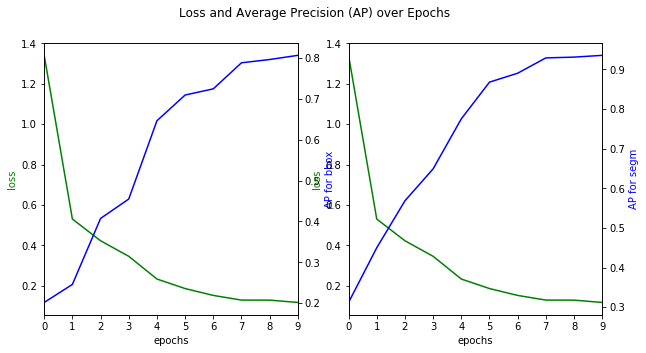

In [11]:
detector.plot_precision_loss_curves()

We can simply run the evaluate() method on our detector to evaluate the results.

In [12]:
e = detector.evaluate()

creating index...
index created!
Test:  [ 0/18]  eta: 0:03:39  model_time: 10.2668 (10.2668)  evaluator_time: 0.0197 (0.0197)  time: 12.1955  data: 1.9088  max mem: 0
Test:  [17/18]  eta: 0:00:10  model_time: 10.3737 (10.2215)  evaluator_time: 0.0316 (0.0528)  time: 10.3883  data: 0.1125  max mem: 0
Test: Total time: 0:03:07 (10.4287 s / it)
Averaged stats: model_time: 10.3737 (10.2215)  evaluator_time: 0.0316 (0.0528)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large 

Plot precision-recall curves.  There are two sets of subplots, one for bounding box, the other for mask.

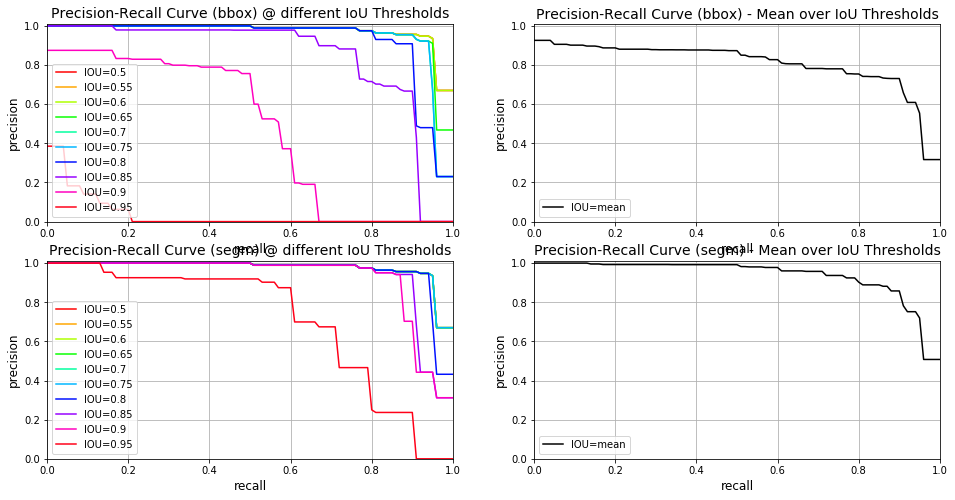

In [13]:
plot_pr_curves(e)

### Predict Single Image

Using the re-trained model, we can predict again.

2


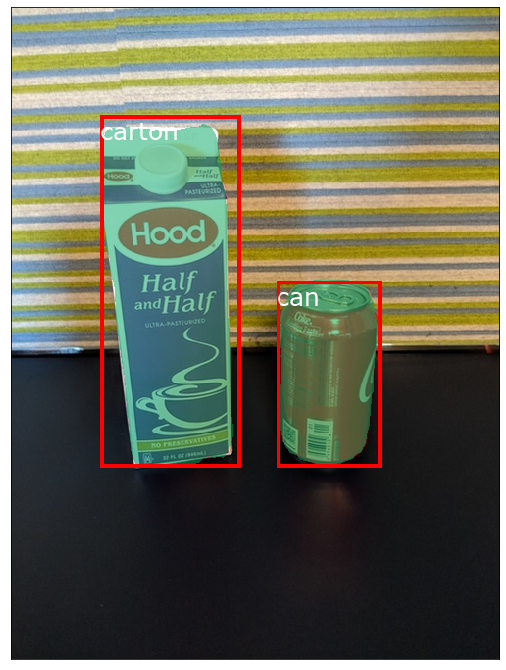

In [14]:
# predict
idx = 18
pred = detector.predict(mask_data.im_paths[idx], threshold=THRESHOLD)
print(len(pred["det_bboxes"]))
# plot
display_bboxes_mask(pred["det_bboxes"], mask_data.im_paths[idx], pred["masks"])

Now we have `milk_bottle` and `can` in the labels of the model.  However, because there are only 31 images annotated with masks, this result is not ideal.

In [15]:
# preserve some of the notebook outputs
sb.glue("training_losses", detector.losses)
sb.glue("training_average_precision", detector.ap)

## Conclusion

In this notebook, we demonstrate how to use the concepts in our [01_training_introduction notebook](01_training_introduction.ipynb) to prepare an Mask R-CNN model detector fine-tuned on your own dataset for instance segmentation.